In [1]:

import pandas as pd
import numpy as np
import os, re
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from scipy.sparse import save_npz

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2, RFE
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

from IPython.display import display


## 1) Load Data


In [2]:
df = pd.read_csv("final_clean_data.csv")
print("Raw shape:", df.shape)
display(df.head())


Raw shape: (633693, 12)


,rating,title,text,asin,user_id,timestamp,product_title,main_category,average_rating,review_length,year,clean_text
0,5.0,Such a lovely scent but not overpowering.,This spray is really nice. It smells really go...,B00YQ6X8EO,AGKHLEW2SOWHNMFQIJGBECAF7INQ,2020-05-05 14:08:48.923,Herbivore - Natural Sea Mist Texturizing Salt ...,All Beauty,4.3,300,2020,spray really nice smells really good goes real...
1,4.0,Works great but smells a little weird.,"This product does what I need it to do, I just...",B081TJ8YS3,AGKHLEW2SOWHNMFQIJGBECAF7INQ,2020-05-04 18:10:55.070,All Natural Vegan Dry Shampoo Powder - Eco Fri...,All Beauty,4.0,235,2020,product need wish odorless soft coconut smell ...
2,1.0,Synthetic feeling,Felt synthetic,B09JS339BZ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,2022-01-28 18:13:50.220,muaowig Ombre Body Wave Bundles 1B Grey Human ...,All Beauty,1.0,14,2022,felt synthetic
3,5.0,A+,Love it,B08BZ63GMJ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,2020-12-30 10:02:43.534,Yinhua Electric Nail Drill Kit Portable Profes...,All Beauty,3.5,7,2020,love
4,4.0,Pretty Color,The polish was quiet thick and did not apply s...,B00R8DXL44,AGMJ3EMDVL6OWBJF7CA5RGJLXN5A,2020-08-27 22:30:08.138,"China Glaze Nail Polish, Wanderlust 1381",All Beauty,3.8,125,2020,polish quiet thick apply smoothly let dry over...


## 2) Quick EDA
- Eksik değer kontrolü
- Yorum uzunluğu dağılımı


Columns: ['rating', 'title', 'text', 'asin', 'user_id', 'timestamp', 'product_title', 'main_category', 'average_rating', 'review_length', 'year', 'clean_text']

Missing values:
rating               0
title              141
text               184
asin                 0
user_id              0
timestamp            0
product_title       69
main_category        0
average_rating       0
review_length        0
year                 0
clean_text        1868
dtype: int64

Text length stats:
count    633693.000000
mean        174.201134
std         250.592227
min           0.000000
25%          44.000000
50%         102.000000
75%         210.000000
max       14989.000000
Name: text_length, dtype: float64


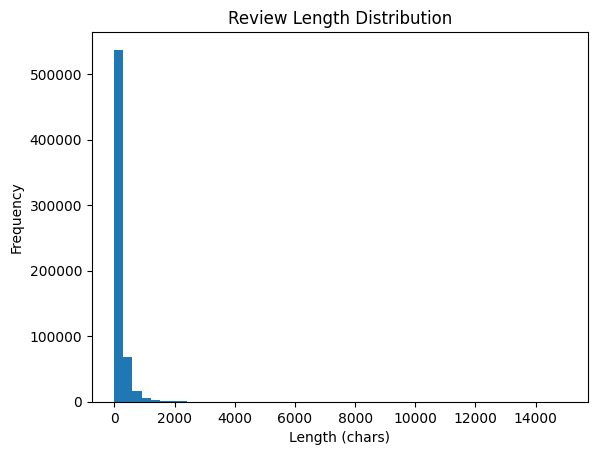

In [3]:
print("Columns:", df.columns.tolist())
print("\nMissing values:")
print(df.isna().sum())

df["text_length"] = df["text"].fillna("").astype(str).str.len()
print("\nText length stats:")
print(df["text_length"].describe())

plt.hist(df["text_length"], bins=50)
plt.title("Review Length Distribution")
plt.xlabel("Length (chars)")
plt.ylabel("Frequency")
plt.show()


## 3) Work on first 50,000 rows
Tüm ekip Outline karşılaştırması için aynı örneklem büyüklüğünü kullanır.


In [4]:
MAX_ROWS = 50000
df = df.head(MAX_ROWS).copy()
print("Working shape:", df.shape)


Working shape: (50000, 13)


## 4) Text Cleaning


In [5]:
def clean_text(s):
    s = str(s).lower()
    s = re.sub(r"http\S+|www\S+", " ", s)
    s = re.sub(r"[^a-z0-9\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

df["title_clean"]  = df["product_title"].fillna("").apply(clean_text)
df["review_clean"] = df["text"].fillna("").apply(clean_text)

display(df[["asin","title_clean","review_clean"]].head())


,asin,title_clean,review_clean
0,B00YQ6X8EO,herbivore natural sea mist texturizing salt sp...,this spray is really nice it smells really goo...
1,B081TJ8YS3,all natural vegan dry shampoo powder eco frien...,this product does what i need it to do i just ...
2,B09JS339BZ,muaowig ombre body wave bundles 1b grey human ...,felt synthetic
3,B08BZ63GMJ,yinhua electric nail drill kit portable profes...,love it
4,B00R8DXL44,china glaze nail polish wanderlust 1381,the polish was quiet thick and did not apply s...


## 5) WordCloud  visualization 


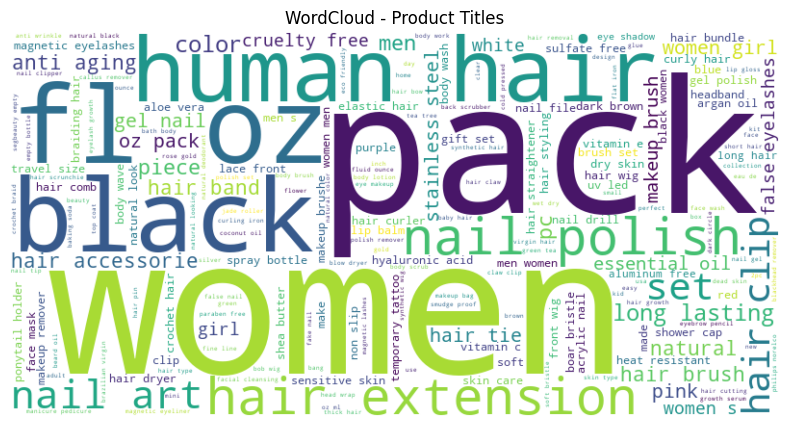

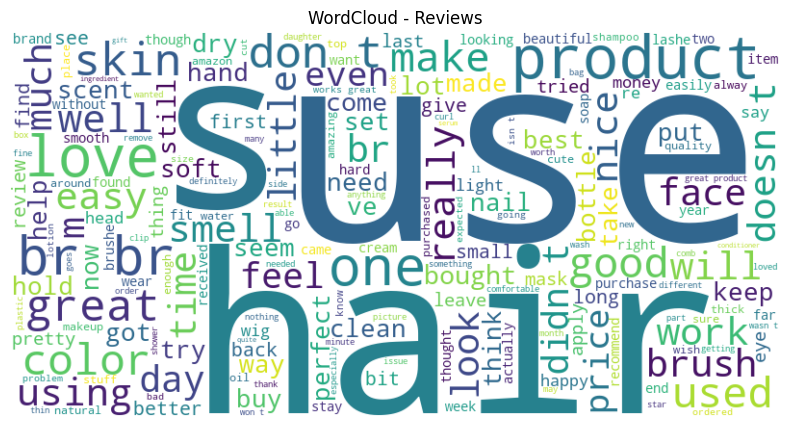

In [6]:
title_text_all  = " ".join(df["title_clean"].tolist())
review_text_all = " ".join(df["review_clean"].tolist())

wc_title = WordCloud(width=800, height=400, background_color="white").generate(title_text_all)
plt.figure(figsize=(12,5))
plt.imshow(wc_title, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud - Product Titles")
plt.show()

wc_review = WordCloud(width=800, height=400, background_color="white").generate(review_text_all)
plt.figure(figsize=(12,5))
plt.imshow(wc_review, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud - Reviews")
plt.show()


## 6) TF‑IDF (Title + Review)
Baseline CBF özellikleri ve Hybrid girdi dosyaları.


In [7]:
os.makedirs("outputs", exist_ok=True)

title_vectorizer = TfidfVectorizer(
    stop_words="english",
    max_features=5000,
    ngram_range=(1,2),
    min_df=1
)
X_title_tfidf = title_vectorizer.fit_transform(df["title_clean"].values)
print("Title TF-IDF shape:", X_title_tfidf.shape)

review_vectorizer = TfidfVectorizer(
    stop_words="english",
    max_features=10000,
    ngram_range=(1,2),
    min_df=3
)
X_review_tfidf = review_vectorizer.fit_transform(df["review_clean"].values)
print("Review TF-IDF shape:", X_review_tfidf.shape)

save_npz("outputs/X_title_tfidf.npz", X_title_tfidf)
save_npz("outputs/X_review_tfidf.npz", X_review_tfidf)

df[["asin"]].to_csv("outputs/asin_list.csv", index=False)


Title TF-IDF shape: (50000, 5000)
Review TF-IDF shape: (50000, 10000)


## 7) Top‑20 Cosine Neighbors (CBF)
NxN matris üretmeden sadece Top‑K komşuları çıkarırız.


In [8]:
def compute_topk_neighbors(X, item_ids, k=20, metric="cosine"):
    nn = NearestNeighbors(
        n_neighbors=k+1,
        metric=metric,
        algorithm="brute",
        n_jobs=-1
    )
    nn.fit(X)
    distances, indices = nn.kneighbors(X, return_distance=True)
    asins = np.array(item_ids)

    rows = []
    for i, src_asin in enumerate(asins):
        for rank, (idx, dist) in enumerate(
            zip(indices[i][1:], distances[i][1:]), start=1
        ):
            rows.append({
                "source_asin": src_asin,
                "neighbor_asin": asins[idx],
                "rank": rank,
                "similarity": float(1 - dist)
            })
    return pd.DataFrame(rows)

asins = df["asin"].values

topk_title_df  = compute_topk_neighbors(X_title_tfidf, asins, k=20)
topk_review_df = compute_topk_neighbors(X_review_tfidf, asins, k=20)

topk_title_df.to_csv("outputs/cbf_title_top20.csv", index=False)
topk_review_df.to_csv("outputs/cbf_review_top20.csv", index=False)

print("CBF outputs saved.")
display(topk_review_df.head())


CBF outputs saved.


,source_asin,neighbor_asin,rank,similarity
0,B00YQ6X8EO,B01CVQALFE,1,0.385241
1,B00YQ6X8EO,B072Z6DWJM,2,0.331798
2,B00YQ6X8EO,B07FSDFV2D,3,0.328175
3,B00YQ6X8EO,B07QDLR1MW,4,0.328175
4,B00YQ6X8EO,B07D9H3SYP,5,0.328175


---

# Outline  Requirement Part
farklılaştırdığı kısım:
1. **RFE Feature Selection**
2. **PCA Dimension Reduction**
3. 2 base model ve tüm aşamalarda karşılaştırma


## 8) Target Definition
rating >= 4 → 1, rating < 4 → 0


In [9]:
if "rating" not in df.columns:
    raise ValueError("rating column not found in cbf_data.csv")

df["label"] = (df["rating"] >= 4).astype(int)


## 9) Train‑Test Split


In [10]:
X = X_review_tfidf
y = df["label"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


## 10) Stage A: Base Models Before FS/DR
Base models:
- Decision Tree
- Logistic Regression


In [11]:
results = []

def eval_stage(Xtr, Xte, stage):
    models = [
        ("DecisionTree", DecisionTreeClassifier(random_state=42)),
        ("LogReg", LogisticRegression(max_iter=1000))
    ]
    for name, model in models:
        model.fit(Xtr, y_train)
        pred = model.predict(Xte)
        results.append({
            "stage": stage,
            "model": name,
            "accuracy": accuracy_score(y_test, pred),
            "f1": f1_score(y_test, pred),
            "precision": precision_score(y_test, pred),
            "recall": recall_score(y_test, pred)
        })

eval_stage(X_train, X_test, "Before_FS_DR")


## 11) Stage B: Feature Selection
### 11.1 Pre‑filter Chi2 (RFE’yi mümkün kılmak için)
Top 5000 kelimeyi tutarız.


In [12]:
prefilter = SelectKBest(chi2, k=5000)
X_train_pf = prefilter.fit_transform(X_train, y_train)
X_test_pf  = prefilter.transform(X_test)


### 11.2 RFE (Logistic Regression estimator)
2000 özellik seçiyoruz. RFE dense ister.


In [13]:
rfe_est = LogisticRegression(max_iter=1000)
rfe = RFE(estimator=rfe_est, n_features_to_select=2000, step=0.1)

X_train_pf_dense = X_train_pf.toarray()
X_test_pf_dense  = X_test_pf.toarray()

X_train_rfe = rfe.fit_transform(X_train_pf_dense, y_train)
X_test_rfe  = rfe.transform(X_test_pf_dense)

eval_stage(X_train_rfe, X_test_rfe, "After_FS_RFE")


## 12) Stage C: PCA Dimension Reduction
300 bileşene indiriyoruz.


In [14]:
pca = PCA(n_components=300, random_state=42)
X_train_pca = pca.fit_transform(X_train_rfe)
X_test_pca  = pca.transform(X_test_rfe)

eval_stage(X_train_pca, X_test_pca, "After_FS_DR_PCA")


## 13) Results Table


In [15]:
results_df = pd.DataFrame(results)
display(results_df)

results_df.to_csv("outputs/bibi_base_models_comparison.csv", index=False)
print("Saved: outputs/bibi_base_models_comparison.csv")


,stage,model,accuracy,f1,precision,recall
0,Before_FS_DR,DecisionTree,0.7935,0.859667,0.859842,0.859492
1,Before_FS_DR,LogReg,0.8669,0.913307,0.877033,0.952711
2,After_FS_RFE,DecisionTree,0.7934,0.859780,0.858847,0.860715
3,After_FS_RFE,LogReg,0.8634,0.911160,0.873768,0.951896
4,After_FS_DR_PCA,DecisionTree,0.7386,0.822080,0.823537,0.820628
5,After_FS_DR_PCA,LogReg,0.8506,0.903538,0.860745,0.950809


Saved: outputs/bibi_base_models_comparison.csv


In [ ]:
 BiBi Sanam Faizi 222040301086 kod dosyasi
 Baseline CBF + WordCloud + Outline (RFE + PCA + Base Models)

Genel Açıklama – Projede Neler Yaptım?

Bu projede büyük bir Amazon ürün yorumları veri seti üzerinde Veri Madenciliği süreçlerini uyguladım. Çalışmanın amacı veriyi anlamak, temizlemek, görselleştirmek ve metin tabanlı modellerle temel sınıflandırma denemeleri yapmaktı. Aşağıda adım adım yaptığım işlemler bulunmaktadır:

1. Veri Yükleme ve İlk İnceleme

Önce final_clean_data.csv dosyasını okudum ve veri setinin boyutuna baktım. Kolon isimlerini kontrol ettim, eksik değer sayılarını çıkardım ve yorum uzunluklarının dağılımını görselleştirdim. Böylece verinin genel yapısını anlamış oldum.

2. Hızlı EDA (Keşifsel Veri Analizi)
	•	Her kolon için eksik değer kontrolü yaptım.
	•	Yorum (text) uzunluklarını hesapladım ve histogram grafiği ile dağılımı gösterdim.
Bu kısım verinin temizliğine ve dengesine karar vermemi sağladı.

3. Metin Temizleme İşlemleri

Ürün başlıkları ve yorumlardan oluşan metin kolonlarını temizledim:
	•	Küçük harfe çevirme
	•	URL, numara ve noktalama temizleme
	•	Gereksiz boşlukları silme
Temizlenmiş veriyi yeni kolonlara ekledim (title_clean, review_clean).

4. WordCloud Görselleştirmeleri

Hem ürün başlıkları için hem de yorum metinleri için kelime bulutları oluşturdum.
Bu görselleştirmeler hangi kelimelerin daha sık geçtiğini anlamama yardımcı oldu.

5. TF-IDF Özellik Çıkarımı (Title + Review)

Temizlenmiş metinlerden TF-IDF özellikleri ürettim:
	•	Başlıklar için 5000 özellik
	•	Yorumlar için 10.000 özellik
Bu matrisleri .npz formatında kaydettim, daha sonra Hybrid modelde kullanılacak.

6. CBF (Content-Based Filtering) – Top-20 Komşu Ürün

TF-IDF matrisleri üzerinden her ürün için en benzer 20 ürünü çıkardım:
	•	Cosine similarity yerine NearestNeighbors ile brute-force kullandım
	•	Hem title hem review için ayrı Top-20 CSV dosyaları oluşturdum:
	•	cbf_title_top20.csv
	•	cbf_review_top20.csv

Bu dosyalar Hybrid modelin girdi veri setidir.

7. Rating’e Göre Label Oluşturma

Sınıflandırma için bir hedef değişken oluşturdum:
	•	Rating > 4 ise 1
	•	Aksi durumda 0
Bu şekilde ikili sınıflandırma problemi kurdum.

8. Train-Test Split

TF-IDF (review) matrisini X olarak, label kolonunu y olarak bölüp %80 eğitim, %20 test ayırdım.

9. Decision Tree ve Logistic Regression Modelleri

Bu iki temel modeli eğittim ve performanslarını karşılaştırdım.
Her model için şu metrikleri hesapladım:
	•	Accuracy
	•	F1-score
	•	Precision
	•	Recall

Bu sonuçlar Feature Selection / PCA öncesi temel performans seviyesini gösteriyor.

Sonuç Olarak:

Bu notebook’ta veriyi yükledim, analiz ettim, temizledim, metinleri işledim, TF-IDF özellikler çıkardım, içerik tabanlı komşuluk listelerini oluşturdum ve son olarak iki farklı sınıflandırma modeli ile ilk aşama değerlendirmesi yaptım. Her bölüm birbirini destekleyecek şekilde hazırlanmış olup sonraki Feature Selection, Dimension Reduction ve Hybrid modeller için temel alt yapıyı oluşturmuştur.